In [9]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from libs.TrafficGenerator import DatasetConvertor 
from libs.TrafficPredictor.ContextAssisted import PreparingDataset as PreparingDatasetCA
from libs.TrafficPredictor.ContextAssisted import trainModelByDefaultSetting as trainModelCA
from libs.TrafficPredictor.ContextAssisted import evaluateModel as evaluateModelCA
from libs.TrafficPredictor.ContextAssisted import createModel as createModelCA
from libs.TrafficPredictor.ContextPerfect import PreparingDataset as PreparingDatasetPerfect
from libs.TrafficPredictor.ContextPerfect import trainModelByDefaultSetting as trainModelPerfect
from libs.TrafficPredictor.ContextPerfect import evaluateModel as evaluateModelPerfect
from libs.TrafficPredictor.ContextPerfect import createModel as createModelPerfect
from libs.TrafficPredictor.ContextFree import PreparingDataset as PreparingDatasetCF
from libs.TrafficPredictor.ContextFree import trainModelByDefaultSetting as trainModelCF
from libs.TrafficPredictor.ContextFree import evaluateModel as evaluateModelCF
from libs.TrafficPredictor.ContextFree import createModel as createModelCF
from libs import encode_float_filename, decode_float_filename

In [10]:
stringFile = encode_float_filename(0.5)
floatFile = decode_float_filename(stringFile)
print(stringFile)
print(floatFile)

5_00e-01.txt
0.5


In [11]:
dbParams = 0.01
direction = "forward"
#dbParams = 0.15
#direction = "backward"
mode = "fixed"
#mode = "adaptive"
alpha = 0.5
lenWindow_list = [30]

rawDatasetFolder = "Dataset"
datasetConverter = DatasetConvertor(rawDatasetFolder)
datasetConverter.processDataset(dbParameter=dbParams, alpha=alpha, mode=mode, direction=direction)
thumbUnit = datasetConverter.getDataUnit('thumb_fr')
#thumbUnit = datasetConverter.getDataUnit('thumb_bk')

========== thumb ============
Forward: Compression rate:0.22314470485360394
========== index ============
Forward: Compression rate:0.24555334544091786
========== middle ============
Forward: Compression rate:0.24907031047306064


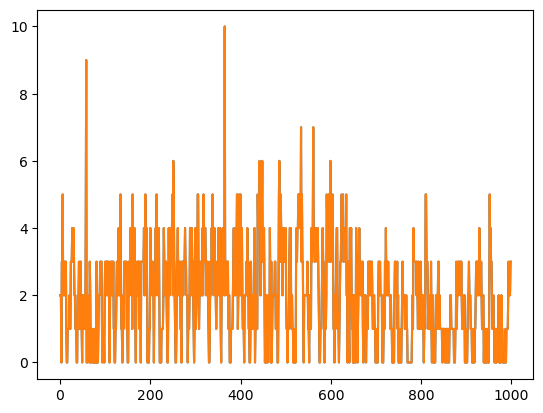

In [12]:
lenWindow = 10
paramsCA = {}
paramsCA['lenSource'] = lenWindow
paramsCA['lenTarget'] = lenWindow
paramsCA['trainRatio'] = 0.8
paramsCA['dataAugment'] = False
paramsCA['smoothFc'] = 2.5
paramsCA['smoothOrder'] = 3
trainDataCA, testDataCA = PreparingDatasetCA(thumbUnit, paramsCA, verbose=False)

paramsCF = {}
paramsCF['lenWindow'] = lenWindow
paramsCF['lenSource'] = 10
paramsCF['lenTarget'] = 1
paramsCF['trainRatio'] = 0.8
paramsCF['dataAugment'] = False

trainDataCF, testDataCF = PreparingDatasetCF(thumbUnit, paramsCF, verbose=False)

trafficCA = testDataCA[5]
trafficCF = testDataCF[1] 
plt.plot(trafficCA[9:1008])
plt.plot(trafficCF[0:1000,0,0])
plt.show()

================== lenWindow = 30 =================


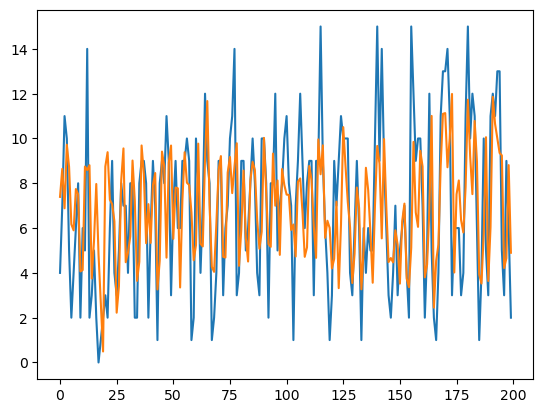

In [13]:
for lenWindow in lenWindow_list:
    print(f"================== lenWindow = {lenWindow} =================")
    trainDataAugment = True
    verbose = False

    paramsCF = {}
    paramsCF['lenWindow'] = lenWindow
    paramsCF['lenSource'] = 10
    paramsCF['lenTarget'] = 1
    paramsCF['trainRatio'] = 0.8
    paramsCF['dataAugment'] = trainDataAugment

    trainData, testData = PreparingDatasetCF(thumbUnit, paramsCF, verbose=verbose)

    bestWeightsCF, _, _, modleParametersCF = trainModelCF(
    paramsCF['lenSource'], paramsCF['lenTarget'], trainData, testData, verbose=verbose)

    trafficModelCF, _ = createModelCF(modleParametersCF)
    trafficModelCF.load_state_dict(bestWeightsCF)

    paramsCF['dataAugment'] = False
    trainDataValid, testDataValid = PreparingDatasetCF(thumbUnit, paramsCF, verbose=verbose)
    actual_trafficCF_train, predicted_trafficCF_train = evaluateModelCF(trafficModelCF, trainDataValid)
    resultsTrain = {}
    resultsTrain['trafficTarget_actual'] = actual_trafficCF_train
    resultsTrain['trafficTarget_predicted'] = predicted_trafficCF_train
    actual_trafficCF_test, predicted_trafficCF_test = evaluateModelCF(trafficModelCF, testDataValid)
    resultsTest = {}
    resultsTest['trafficTarget_actual'] = actual_trafficCF_test
    resultsTest['trafficTarget_predicted'] = predicted_trafficCF_test

    plt.plot(resultsTest['trafficTarget_actual'][0:200])
    plt.plot(resultsTest['trafficTarget_predicted'][0:200])
    plt.show()

    #============= Save Results =============
    dbpString = encode_float_filename(dbParams)
    with open(f"Results/TrafficPredictor/evaluate/CF/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "wb") as file:
        pickle.dump(resultsTrain, file)
    with open(f"Results/TrafficPredictor/evaluate/CF/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "wb") as file:
        pickle.dump(resultsTest, file)

================== lenWindow = 30 =================
Train size: 83253, Test size: 20814
(83193, 30, 3)
(83193, 1, 3)
Size of train loader: 21, Size of test loader: 6
Used device: cuda
Size of model: 49790
TrafficPredictorContextAssisted(
  (dbf2traffic): DeadFeaturesToTrafficLayer(
    (input_layer): Sequential(
      (0): Linear(in_features=496, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.9, inplace=False)
    )
    (hidden_layers): ModuleList(
      (0-2): 3 x Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.9, inplace=False)
      )
    )
    (trans2transmission_layer): Linear(in_features=64, out_features=30, bias=True)
    (sigmoid): Sigmoid()
    (trans2traffic_layer): Linear(in_features=94, out_features=

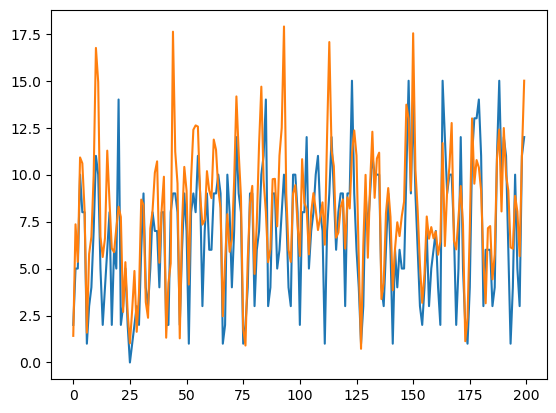

In [14]:
for lenWindow in lenWindow_list:
    print(f"================== lenWindow = {lenWindow} =================")
    trainDataAugment = True
    verbose = True

    paramsCA = {}
    paramsCA['lenSource'] = lenWindow
    paramsCA['lenTarget'] = lenWindow
    paramsCA['trainRatio'] = 0.8
    paramsCA['dataAugment'] = trainDataAugment
    paramsCA['smoothFc'] = 1.5
    paramsCA['smoothOrder'] = 3

    #============= Training =============
    trainData, testData = PreparingDatasetPerfect(thumbUnit, paramsCA, verbose=verbose)
    (sources, _, lastTranmittedContext, _, _, _, _) = trainData
    print(sources.shape)
    print(lastTranmittedContext.shape)
    bestWeightsPerfect, _, _, modleParametersPerfect = trainModelPerfect(
    paramsCA['lenSource'], paramsCA['lenTarget'], trainData, testData, verbose=verbose)

    #============= Evaluatation =============
    trafficModelPerfect, _ = createModelPerfect(modleParametersPerfect)
    trafficModelPerfect.load_state_dict(bestWeightsPerfect)
    paramsValid = paramsCA.copy()
    paramsValid['dataAugment'] = False
    trainData, testData = PreparingDatasetPerfect(thumbUnit, paramsValid, verbose=verbose)
    resultsTrain = evaluateModelPerfect(trafficModelPerfect, trainData)
    resultsTest = evaluateModelPerfect(trafficModelPerfect, testData)

    #print(f"actual_class_shape: {resultsTrain['classDistribu_actual'].shape}, predicted_class_shape: {resultsTrain['classDistribu_predicted'].shape}")

    plt.plot(resultsTest['trafficTarget_actual'][0:200])
    plt.plot(resultsTest['trafficTarget_predicted'][0:200])
    plt.show()

    #============= Save Results =============
    dbpString = encode_float_filename(dbParams)
    with open(f"Results/TrafficPredictor/evaluate/Perfect/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "wb") as file:
        pickle.dump(resultsTrain, file)
    with open(f"Results/TrafficPredictor/evaluate/Perfect/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "wb") as file:
        pickle.dump(resultsTest, file)

In [ ]:
for lenWindow in lenWindow_list:
    print(f"================== lenWindow = {lenWindow} =================")
    trainDataAugment = True
    verbose = True

    paramsCA = {}
    paramsCA['lenSource'] = lenWindow
    paramsCA['lenTarget'] = lenWindow
    paramsCA['trainRatio'] = 0.8
    paramsCA['dataAugment'] = trainDataAugment
    paramsCA['smoothFc'] = 1.5
    paramsCA['smoothOrder'] = 3

    #============= Training =============
    trainData, testData = PreparingDatasetCA(thumbUnit, paramsCA, verbose=verbose)
    (sources, _, lastTranmittedContext, _, _, _, _) = trainData
    print(sources.shape)
    print(lastTranmittedContext.shape)
    bestWeightsCA, _, _, modleParametersCA = trainModelCA(
    paramsCA['lenSource'], paramsCA['lenTarget'], trainData, testData, verbose=False)

    #============= Evaluatation =============
    trafficModelCA, _ = createModelCA(modleParametersCA)
    trafficModelCA.load_state_dict(bestWeightsCA)
    paramsValid = paramsCA.copy()
    paramsValid['dataAugment'] = False
    trainData, testData = PreparingDatasetCA(thumbUnit, paramsValid, verbose=verbose)
    resultsTrain = evaluateModelCA(trafficModelCA, trainData)
    resultsTest = evaluateModelCA(trafficModelCA, testData)

    #print(f"actual_class_shape: {resultsTrain['classDistribu_actual'].shape}, predicted_class_shape: {resultsTrain['classDistribu_predicted'].shape}")

    plt.plot(resultsTest['trafficTarget_actual'][0:200])
    plt.plot(resultsTest['trafficTarget_predicted'][0:200])
    plt.show()

    #============= Save Results =============
    dbpString = encode_float_filename(dbParams)
    with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "wb") as file:
        pickle.dump(resultsTrain, file)
    with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "wb") as file:
        pickle.dump(resultsTest, file)
    with open(f"Results/TrafficPredictor/modelParams/{direction}_{lenWindow}_{mode}_{dbpString}.pkl", "wb") as file:
        pickle.dump(modleParametersCA, file)
    torch.save(bestWeightsCA, f"Results/TrafficPredictor/model/{direction}_{lenWindow}_{mode}_{dbpString}.pth")

================== lenWindow = 30 =================
Train size: 83253, Test size: 20814
(83193, 30, 3)
(83193, 1, 3)


In [ ]:

dbpString = encode_float_filename(dbParams)
with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "rb") as file:
    resultsCA_Train = pickle.load(file)
with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "rb") as file:
    resultsCA_Test = pickle.load(file)
with open(f"Results/TrafficPredictor/evaluate/CF/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "rb") as file:
    resultsCF_Train = pickle.load(file)
with open(f"Results/TrafficPredictor/evaluate/CF/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "rb") as file:
    resultsCF_Test = pickle.load(file)
with open(f"Results/TrafficPredictor/evaluate/Perfect/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "rb") as file:
    resultsPerfect_Train = pickle.load(file)
with open(f"Results/TrafficPredictor/evaluate/Perfect/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "rb") as file:
    resultsPerfect_Test = pickle.load(file)

mseCA = np.mean(np.square(resultsCA_Test["trafficTarget_actual"] - resultsCA_Test["trafficTarget_predicted"]))
mseCF = np.mean(np.square(resultsCF_Test["trafficTarget_actual"] - resultsCF_Test["trafficTarget_predicted"]))
msePerfect = np.mean(np.square(resultsPerfect_Test["trafficTarget_actual"] - resultsPerfect_Test["trafficTarget_predicted"]))
print(f"Perfect MSE: {msePerfect:.4f}, CF MSE: {mseCF:.4f}, CA MSE: {mseCA:.4f}")

Perfect MSE: 1.1894, CF MSE: 1.3966, CA MSE: 1.0764
